# Import Libraries

In [104]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [105]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [106]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [107]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [108]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=15, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 6


        self.gap = nn.AvgPool2d(kernel_size = 6)

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1 7x7x10 | 7x7x10x10 | 1x1x10
        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.dropout(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [109]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
       BatchNorm2d-6           [-1, 15, 24, 24]              30
              ReLU-7           [-1, 15, 24, 24]               0
           Dropout-8           [-1, 15, 24, 24]               0
            Conv2d-9           [-1, 20, 24, 24]             300
      BatchNorm2d-10           [-1, 20, 24, 24]              40
             ReLU-11           [-1, 20, 24, 24]               0
        MaxPool2d-12           [-1, 20, 12, 12]               0
           Conv2d-13           [-1, 10, 10, 10]           1,800
      BatchNorm2d-14           [-1

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [110]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [111]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09561488032341003 Batch_id=468 Accuracy=73.47: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]



Test set: Average loss: 0.2566, Accuracy: 9372/10000 (93.72%)

EPOCH: 1


Loss=0.13551869988441467 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]



Test set: Average loss: 0.0811, Accuracy: 9768/10000 (97.68%)

EPOCH: 2


Loss=0.07362069189548492 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0656, Accuracy: 9803/10000 (98.03%)

EPOCH: 3


Loss=0.03462260961532593 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]



Test set: Average loss: 0.0636, Accuracy: 9816/10000 (98.16%)

EPOCH: 4


Loss=0.049004197120666504 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]



Test set: Average loss: 0.0490, Accuracy: 9861/10000 (98.61%)

EPOCH: 5


Loss=0.04397600516676903 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:26<00:00, 17.37it/s]



Test set: Average loss: 0.0394, Accuracy: 9879/10000 (98.79%)

EPOCH: 6


Loss=0.11773747205734253 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]



Test set: Average loss: 0.0536, Accuracy: 9844/10000 (98.44%)

EPOCH: 7


Loss=0.024730637669563293 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]



Test set: Average loss: 0.0386, Accuracy: 9880/10000 (98.80%)

EPOCH: 8


Loss=0.07362905889749527 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]



Test set: Average loss: 0.0300, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.04441488906741142 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]



Test set: Average loss: 0.0383, Accuracy: 9885/10000 (98.85%)

EPOCH: 10


Loss=0.04608110710978508 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:29<00:00, 15.67it/s]



Test set: Average loss: 0.0341, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.10314036160707474 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:28<00:00, 16.50it/s]



Test set: Average loss: 0.0318, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


Loss=0.027363205328583717 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]



Test set: Average loss: 0.0327, Accuracy: 9892/10000 (98.92%)

EPOCH: 13


Loss=0.06603245437145233 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]



Test set: Average loss: 0.0317, Accuracy: 9898/10000 (98.98%)

EPOCH: 14


Loss=0.022887663915753365 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]



Test set: Average loss: 0.0361, Accuracy: 9893/10000 (98.93%)

EPOCH: 15


Loss=0.07704082131385803 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]



Test set: Average loss: 0.0305, Accuracy: 9905/10000 (99.05%)

EPOCH: 16


Loss=0.01002801675349474 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s]



Test set: Average loss: 0.0298, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.12509028613567352 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]



Test set: Average loss: 0.0272, Accuracy: 9912/10000 (99.12%)

EPOCH: 18


Loss=0.010606658644974232 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:28<00:00, 16.70it/s]



Test set: Average loss: 0.0315, Accuracy: 9898/10000 (98.98%)

EPOCH: 19


Loss=0.04330972209572792 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]



Test set: Average loss: 0.0299, Accuracy: 9907/10000 (99.07%)



In [58]:
train_losses

[tensor(2.3388, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3361, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2789, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3110, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3602, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2854, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3034, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2799, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2801, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2867, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2545, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2929, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2640, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2557, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2552, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [21]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

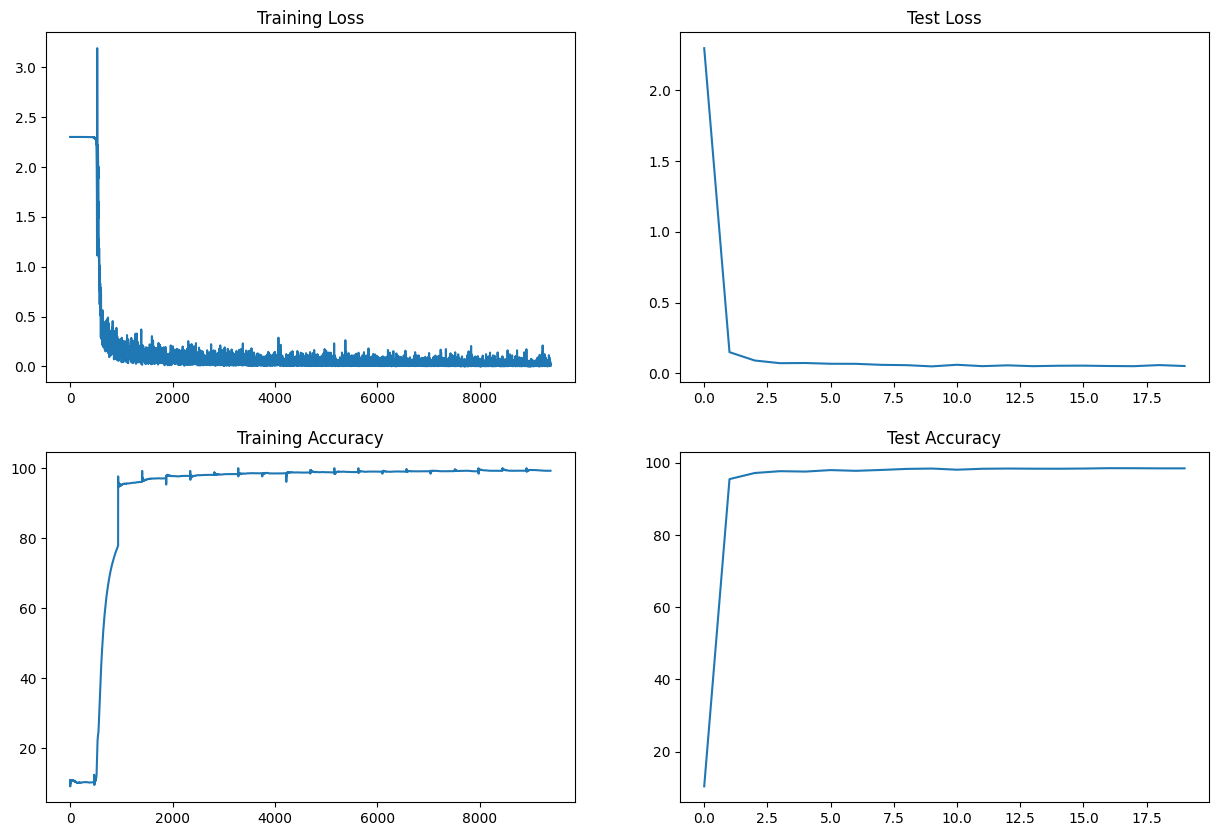

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")